# Bond Option Pricing using Black-Karasinski Model

In [1]:
# This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; 
# without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  
# See the license for more details.

Value an option on a coupon paying bond using the Black-Karasinski model

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from financepy.finutils.FinDate import FinDate
from financepy.market.curves.FinDiscountCurve import FinDiscountCurve
from financepy.finutils.FinFrequency import FinFrequencyTypes
from financepy.finutils.FinDayCount import FinDayCountTypes
from financepy.products.libor.FinLiborSwap import FinLiborSwap
from financepy.market.curves.FinLiborCurve import FinLiborCurve
from financepy.models.FinModelRatesBK import FinModelRatesBK
from financepy.products.bonds.FinBond import FinBond
from financepy.products.bonds.FinBondOption import *

## Bond Option Valuation

In [3]:
settlementDate = FinDate(1, 12, 2019)

Set up discount curve

In [4]:
dcType = FinDayCountTypes.ACT_360
fixedFreq = FinFrequencyTypes.SEMI_ANNUAL
swap1 = FinLiborSwap(settlementDate,"1Y",0.0500,fixedFreq,dcType)
swap2 = FinLiborSwap(settlementDate,"3Y",0.0500,fixedFreq,dcType)
swap3 = FinLiborSwap(settlementDate,"5Y",0.0500,fixedFreq,dcType)
swap4 = FinLiborSwap(settlementDate,"7Y",0.0500,fixedFreq,dcType)
swap5 = FinLiborSwap(settlementDate,"10Y",0.0500,fixedFreq,dcType)
swaps = [swap1, swap2, swap3, swap4, swap5]

liborCurve = FinLiborCurve("USD_LIBOR", settlementDate, [], [], swaps)

In [6]:
print(liborCurve)

TIME: DISCOUNT FACTOR
0.0: 1.0
1.0020753363523363: 0.951171476582115
3.0007501875468865: 0.8605477361825261
5.004900860251559: 0.7783474070247896
7.000837800691048: 0.7042850184605135
10.007063809748058: 0.6058235211723398



## Set up the Bond Option

First create the bond

In [7]:
maturityDate = settlementDate.addTenor("10Y")
coupon = 0.05
frequencyType = FinFrequencyTypes.SEMI_ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(maturityDate, coupon, frequencyType, accrualType)

Let's first price the bond on the libor curve

In [8]:
price = bond.valueBondUsingDiscountCurve(settlementDate, liborCurve, False)
print("Fixed Income Price:", price)

Fixed Income Price: 99.44194023625118


Then define and create the option

In [9]:
expiryDate = settlementDate.addTenor("18m")
strikePrice = 90.0
face = 100.0
optionType = FinBondOptionTypes.AMERICAN_CALL

### Black Karasinski Model

Set the model parameters

In [10]:
sigma = 0.20
a = 0.05
bkModel = FinModelRatesBK(a, sigma)

In [11]:
strikes = [80, 85, 90, 95, 100, 105, 110, 115, 120]

In [12]:
for K in strikes:
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, liborCurve, bkModel)
    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, liborCurve, bkModel)
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, liborCurve, bkModel)
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, liborCurve, bkModel)
    
    print("K: %9.5f EUR_CALL: %9.5f  AMER_CALL: %9.5f  EUR_PUT: %9.5f  AMER_PUT: %9.5f" %(K, v_ec, v_ac, v_ep, v_ap))

K:  80.00000 EUR_CALL:  18.77181  AMER_CALL:  19.44194  EUR_PUT:   0.01350  AMER_PUT:   0.01412
K:  85.00000 EUR_CALL:  14.05681  AMER_CALL:  14.44194  EUR_PUT:   0.07231  AMER_PUT:   0.07437
K:  90.00000 EUR_CALL:   9.30954  AMER_CALL:   9.71902  EUR_PUT:   0.29730  AMER_PUT:   0.31315
K:  95.00000 EUR_CALL:   5.41883  AMER_CALL:   5.55770  EUR_PUT:   1.06221  AMER_PUT:   1.09773
K: 100.00000 EUR_CALL:   2.30437  AMER_CALL:   2.45815  EUR_PUT:   2.76913  AMER_PUT:   2.92109
K: 105.00000 EUR_CALL:   0.63886  AMER_CALL:   0.64774  EUR_PUT:   6.03644  AMER_PUT:   6.26546
K: 110.00000 EUR_CALL:   0.10044  AMER_CALL:   0.10309  EUR_PUT:  10.24072  AMER_PUT:  10.69796
K: 115.00000 EUR_CALL:   0.00479  AMER_CALL:   0.00579  EUR_PUT:  14.87056  AMER_PUT:  15.55806
K: 120.00000 EUR_CALL:   0.00006  AMER_CALL:   0.00006  EUR_PUT:  19.81029  AMER_PUT:  20.55806


## Convergence Testing - Black-Karasinski

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

In [13]:
from financepy.market.curves.FinFlatCurve import FinFlatCurve

In [14]:
print(settlementDate)

SUN 1 DEC 2019


In [15]:
discountCurve = FinFlatCurve(settlementDate, 0.05)

In [16]:
maturityDate = FinDate(1, 9, 2025)
coupon = 0.05
frequencyType = FinFrequencyTypes.ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(maturityDate, coupon, frequencyType, accrualType)
expiryDate = settlementDate.addTenor("18m")
face = 100.0

In [17]:
numStepsVector = range(50,1000,10)

In [18]:
sigma = 0.20
a = 0.05

In [19]:
K = 102.0

In [20]:
vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for numSteps in numStepsVector:
    
    bkModel = FinModelRatesBK(a, sigma, numSteps)
    
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, bkModel)

    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, bkModel)
    
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, bkModel)
    
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinBondOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, bkModel)
    
    # print("%d %9.5f %9.5f %9.5f %9.5f"%(numSteps, v_ec, v_ac, v_ep, v_ap))
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

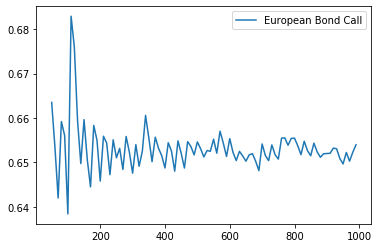

In [24]:
plt.plot(numStepsVector,vec_ec, label="European Bond Call")
plt.legend()

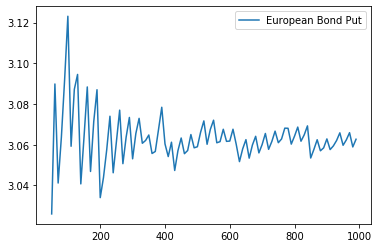

In [26]:
plt.plot(numStepsVector,vec_ep, label="European Bond Put")
plt.legend()

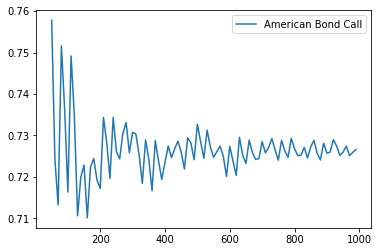

In [27]:
plt.plot(numStepsVector,vec_ac, label="American Bond Call")
plt.legend()

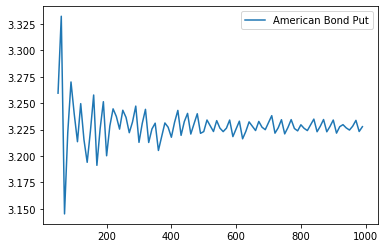

In [28]:
plt.plot(numStepsVector,vec_ap, label="American Bond Put")
plt.legend()